# Segmentation with Text Prompt: GroundingDINO + SAM2

This notebook shows how to integrate GroundingDINO and SAM2 to segment objects from an image using text prompts.

**Segment Anything Model 2 (SAM2)** is a method that performs segmentation on images (as well as videos) based on prompts. The prompts here includes coordinate points or bounding boxes of interested objects, which should be manually defined. That means, if I want to segment a cat from an image, I need to either know the coordinate points of the cat in the image, or know the bounding box of the cat. Can we automate this process of finding the coordinate points or bounding boxes? 

**GroundingDINO** is an object detector that detects objects in an image based on text prompts. That means, we can use natural language to tell the detector what objects we want to find, and the detector will output bounding boxes of our interest objects. It does not perform segmentation, however, it only performs object detection. Thus, why not applying SAM2 after the detector has identified the bounding boxes of our interested objects?

Let's explore how we can combine these two methods to segment our interested objects using text prompts.

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Setup and Installation](#setup)
- [Import Libraries](#import)
- [Object Localization with Text Prompt](#localization)
- [Object Segmentation with Boxes Prompt](#segmentation)
- [Putting GroundingDINO And SAM2 Together](#together)
- [More Challenging Text Prompt](#challenging)
    
Reference: 
- Github: https://github.com/IDEA-Research/GroundingDINO, https://github.com/facebookresearch/sam2
- Papers: https://arxiv.org/pdf/2303.05499, https://arxiv.org/abs/2408.00714

# Setup and Installation <a class='anchor' id='setup'></a> [↑](#top)

First, we need to setup the environment and install the required dependencies for both GroundingDINO and SAM2.

Before that, we need to check if the environment variable `CUDA_HOME` has been set by using the command following command. 

In [ ]:
!echo $CUDA_HOME

: 

If the above command prints nothing, that means the variable has not been set. We then need to check the path to the cuda using command `!which nvcc`, and then set the variable using `!export CUDA_HOME=<path-to-cuda>`, where `<path-to-cuda>` is the output of `!which nvcc`.

Now we can clone the GroundingDINO Github repository and install the required dependencies.

In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO/
!pip install -q -e .

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Total 463 (delta 0), reused 0 (delta 0), pack-reused 463 (from 1)
Receiving objects: 100% (463/463), 12.91 MiB | 11.55 MiB/s, done.
Resolving deltas: 100% (220/220), done.
/Users/pp/Desktop/solution_deployment_project/GroundingDINO
zsh:1: command not found: pip


/Users/pp/Library/Python/3.9/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


We can now download the GroundingDINO pre-trained model's weights to be used for our inference (or prediction) later.

In [2]:
!mkdir weights
%cd weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
%cd ..

/Users/pp/Desktop/solution_deployment_project/GroundingDINO/weights
zsh:1: command not found: wget
/Users/pp/Desktop/solution_deployment_project/GroundingDINO


Similarly, for SAM2, we can clone its Github repository and install its dependencies.

In [3]:
%cd ..
!git clone https://github.com/facebookresearch/sam2.git
%cd sam2
!pip install -q -e .

/Users/pp/Desktop/solution_deployment_project
Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/Users/pp/Desktop/solution_deployment_project/sam2
zsh:1: command not found: pip


In [4]:
%cd sam2
!pip install -q -e .

/Users/pp/Desktop/solution_deployment_project/sam2/sam2
ERROR: file:///Users/pp/Desktop/solution_deployment_project/sam2/sam2 does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


We also need to download the pre-trained SAM2 model checkpoints. 

In [ ]:
%cd sam2
!mkdir -p checkpoints/
!wget -P checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
%cd ..    

/kaggle/working/sam2/sam2
--2024-10-31 04:21:42--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.79, 18.165.83.35, 18.165.83.91, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898083611 (856M) [application/vnd.snesdev-page-table]
Saving to: 'checkpoints/sam2.1_hiera_large.pt'

sam2.1_hiera_large. 100%[===================>] 856.48M   283MB/s    in 3.0s    

2024-10-31 04:21:45 (283 MB/s) - 'checkpoints/sam2.1_hiera_large.pt' saved [898083611/898083611]

/kaggle/working/sam2


In [ ]:
%cd ..

/kaggle/working


# Import Libraries <a class='anchor' id='import'></a> [↑](#top)

After finishing the environment setup and installation, we can import some required libraries.

In [7]:
%cd /kaggle/working/GroundingDINO
from groundingdino.util.inference import load_model, load_image, predict, annotate

/kaggle/working/GroundingDINO


In [8]:
%cd /kaggle/working/sam2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

/kaggle/working/sam2


In [9]:
%cd /kaggle/working/
import cv2
import os
import torch
from torchvision.ops import box_convert
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

/kaggle/working


# Object Localization with Text Prompt <a class='anchor' id='localization'></a> [↑](#top)

We first explore the GroundingDINO method that takes an image and text prompt as input, and outputs a list of bounding boxes that matches the prompt.

Here, we will use a pre-trained model, so we need to load it first.

In [10]:
model = load_model("GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "GroundingDINO/weights/groundingdino_swint_ogc.pth")

final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

We set our input arguments. Please change the `IMAGE_PATH` to our own image, and set a `TEXT_PROMPT` that tells the objects that you would like to detect in the image. Following the suggestion from GroundingDINO Github page, we separate different category names with `.`. The text prompt can be a sentence as well, not necessary words. The `BOX_TRESHOLD` and `TEXT_TRESHOLD` set here are the default values.

In [ ]:
IMAGE_PATH = "test_data/desk.jpg"
TEXT_PROMPT = "book . ball . bottle ."
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

In [12]:
image_source, image = load_image(IMAGE_PATH)

Now, we use the `predict()` function that we imported earlier to predict the bounding boxes based on the input prompt.

In [13]:
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

We can use the `annotate()` function to create an image with the output bounding boxes and their respective category names and confidence scores.

In [14]:
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

Let's visualize the results 👀

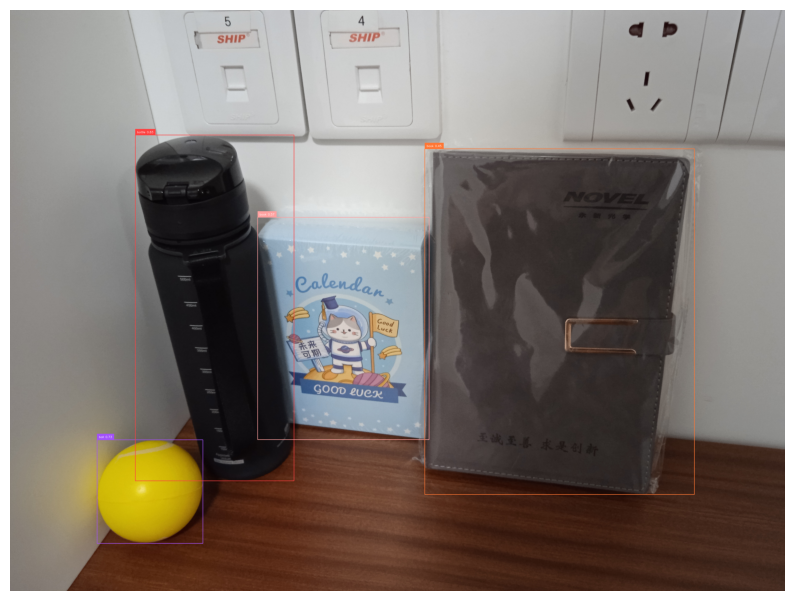

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Save the result to a specified path.

In [ ]:
cv2.imwrite("output/desk-annotated_image.jpg", annotated_frame)

We have done with object detection using text prompt with GroundingDINO 😃 But before we pass these bounding boxes to our SAM2 model, we need to do some modifications to the format of the bounding boxes so that the SAM2 can function properly. 

Here is the code for converting the list of bounding boxes to a format recognize by SAM2.

In [17]:
h, w, _ = image_source.shape
boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()

# Object Segmentation with Boxes Prompt <a class='anchor' id='segmentation'></a> [↑](#top)

Now let's explore SAM2.

We have obtained bounding boxes using GroundingDINO previously, and we want the SAM2 to properly segment the objects in the bounding boxes.

For simplicity, we change our working path to `/kaggle/working/sam2`.

In [ ]:
%cd sam2

Load the pre-trained SAM2 model. Here we choose `hiera_large` model, so we specify its corresponding checkpoints that we downloaded earlier, and the pre-defined configuration file (this is installed together when we clone the repository). We then create a SAM2 model and a predictor to predict the segments (SAM2 also has a generator automatically generates segmentation masks for the whole image, not a specific category or class, but we won't use it here).

In [ ]:
sam2_checkpoint = "sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device='cpu')

predictor = SAM2ImagePredictor(sam2_model)

Define some helper function responsible for plotting the results.

In [20]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

Now we can load our image and predict the segmentation masks. We use the same input image as above, and set the image to the SAM2 predictor using `set_image()`.

In [ ]:
image = Image.open('test_data/desk.jpg')
image = np.array(image.convert("RGB"))
predictor.set_image(image)

Then, we just call the `predict()` function and pass the bounding boxes we obtained previously (`boxes_xyxy`) as input. We will obtain the segmentation masks and their corresponding confidence scores.

In [22]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=boxes_xyxy,
    multimask_output=False,
)

Let's visualize the segmentation output 👀 The following code will also save the output to `desk-segment.jpg`, change this path if necessary.

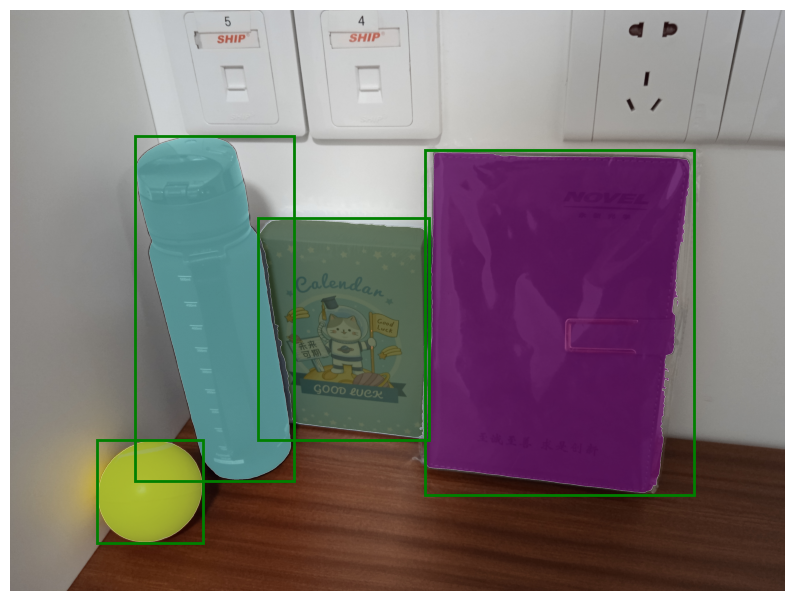

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in boxes_xyxy:
    show_box(box, plt.gca())
plt.axis('off')
plt.savefig("desk-segment.jpg")
plt.show()

# Putting GroundingDINO And SAM2 Together <a class='anchor' id='together'></a> [↑](#top)

This section chains GroundingDINO and SAM2 together in a single function `segment_with_prompt()`. Everything is the same as what we did in previous sections, but we now put everything in a single function so that we can perform segmentation on different images by simply calling this function 😎

Before running the codes below, **make sure you have properly [install all required packages / dependencies](#setup) and [import all the necessary libraries](#import)**.

<div class="alert alert-block alert-warning">  
<b>For simplicity, we fix our working path at /kaggle/working/sam2.</b> 
If this is not your current working path, run this command: %cd /kaggle/working/sam2.
</div>

The following helper functions `show_mask` and `show_box` are exactly the same as in the previous section, but let us just define it again.

In [24]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

Now, we load the pre-trained GroundingDINO model and SAM2 model using their configuration files and checkpoints / weights. We also initialize a predictor for the SAM2 model.

<div class="alert alert-block alert-info">
If you would like to use a different model configurations or checkpoints, feel free to change the corresponding paths.
</div>

*Check the available checkpoints for [GroundingDINO model](https://github.com/IDEA-Research/GroundingDINO?tab=readme-ov-file#luggage-checkpoints) and [SAM2 model](https://github.com/facebookresearch/sam2/#download-checkpoints).*

In [ ]:
model = load_model("GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "GroundingDINO/weights/groundingdino_swint_ogc.pth")
sam2_model = build_sam2("sam2/configs/sam2.1/sam2.1_hiera_l.yaml", "sam2/sam2/checkpoints/sam2.1_hiera_large.pt", device='cpu')
predictor = SAM2ImagePredictor(sam2_model)

In [26]:
def segment_with_prompt(image_path, save_path, model, predictor, text_prompt, box_treshold=0.35, text_treshold=0.25):
    
    image_source, image = load_image(image_path)
    
    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=text_prompt,
        box_threshold=box_treshold,
        text_threshold=text_treshold
    )
    
    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    output_path = os.path.join(save_path, os.path.splitext(os.path.basename(image_path))[0] + '-annotated.jpg')
    
    cv2.imwrite(output_path, annotated_frame)
    
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    
    image = Image.open(image_path)
    image = np.array(image.convert("RGB"))
    predictor.set_image(image)
    
    masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=boxes_xyxy,
        multimask_output=False,
    )
    
    output_path = os.path.join(save_path, os.path.splitext(os.path.basename(image_path))[0] + '-segment.jpg')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for mask in masks:
        if len(mask.shape) > 2:
            show_mask(mask.squeeze(0), plt.gca(), random_color=True)
        else:
            show_mask(mask, plt.gca(), random_color=True)
    for box in boxes_xyxy:
        show_box(box, plt.gca())
    plt.axis('off')
    plt.savefig(output_path)
    plt.show()

Create a directory to store all the outputs.

In [ ]:
!mkdir -p output/

We have done with defining our function, and now we can just call our function and pass necessary arguments:
- `image_path`: Path to our interest image
- `save_path`: Path to save the output images
- `model`: Initialized GroundingDINO model
- `predictor`: Initialized SAM2 predictor
- `text_prompt`: A text prompt of our interetsed objects in the target image

Let's see some examples 🖼️

In [ ]:
IMAGE_PATH = "test_data/box.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "kalimba . box ."

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

In [ ]:
IMAGE_PATH = "test_data/cat.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "A cat"

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

In [ ]:
IMAGE_PATH = "test_data/geese.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "Geese"

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

# More Challenging Text Prompt <a class='anchor' id='challenging'></a> [↑](#top)

Let's try some more challenging text prompt to see if GroundingDINO can correctly localize our target objects and SAM2 can accurately segment the object. What I meant by "challenging" prompts are texts that includes descriptions (adjectives / adverbs) of an object.

I have an image with a few trees, but only two of them have white flowers / leaves, the others are green and red. Let's try to detect and segment only the **white trees**.

In [ ]:
IMAGE_PATH = "test_data/tree.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "Trees with white flowers"

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

<div class="alert alert-block alert-success">  
Great 👍 Only the white trees are segmented! 
</div>

Let's try a picture with four cute panda dolls, and ask it to find panda with yellow shirt.

In [ ]:
IMAGE_PATH = "test_data/panda.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "Panda in yellow shirt"

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

<div class="alert alert-block alert-danger">  
Hmm... well, it detects both "panda" and "yellow shirts", which is not what I want (or am I using a wrong grammar in my prompt 🤣).
</div>

Maybe let's try another prompt using the same image. Let's segment the leftmost panda.

In [ ]:
IMAGE_PATH = "test_data/panda.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "Leftmost panda"

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

<div class="alert alert-block alert-danger">  
Doesn't work too... 🙁 But notice that the GroundingDINO classifies the green and orange panda as "##most panda" (which I believe means the left most panda) while the other two are just "panda".
</div>

Let's use our geese image and ask it to segment the front-most goose. As human, we can immediately tell the which direction the geese are moving towards from this image (we know which direction the geese are facing), thus we can tell which goose is walking at the front.

In [ ]:
IMAGE_PATH = "test_data/geese.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "Front-most goose"

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

<div class="alert alert-block alert-success">  
<b>Suprisingly 😲</b> it detects only a single goose, unlike the above panda example.  
</div>

But the detected goose is actually walking at the last, not the front. Perhaps the GroundingDINO misunderstood "front-most goose" as the goose that is nearest to the viewpoint? 

Maybe we can try a clearer text prompt "goose that walks at the front" to see what happens.

In [ ]:
IMAGE_PATH = "test_data/geese.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "Goose that walks at the front"

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

<div class="alert alert-block alert-danger">  
Same result. I think my prompt is clear enough, so I don't think it is a misunderstanding issue.
</div>

Let's try another image with mirror reflection. It is an image of a rabbit doll looking at itself through a mirror 🐇 Can GroundingDINO differentiate between the real rabbit and the reflected rabbit?

In [ ]:
IMAGE_PATH = "test_data/mirror.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "Real rabbit"

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

<div class="alert alert-block alert-danger">  
It can't identify the real rabbit 🙁
</div>

Let's change a prompt to "rabbit inside the mirror".

In [ ]:
IMAGE_PATH = "test_data/mirror.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "Rabbit inside the mirror"

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

<div class="alert alert-block alert-danger">  
This prompt does not work either 🙁
</div>

What about "rabbit's reflection"?

In [ ]:
IMAGE_PATH = "test_data/mirror.jpg"
SAVE_PATH = "output"
TEXT_PROMPT = "Rabbit's reflection"

segment_with_prompt(IMAGE_PATH, SAVE_PATH, model, predictor, TEXT_PROMPT)

<div class="alert alert-block alert-success">  
Surprise 😮 It knows which is the "rabbit's reflection" but does not know which is "rabbit inside the mirror".
</div>

Generally, GroundingDINO + SAM2 works quite well in localizing our interest objects and segment them. However, in some challenging cases or prompts, its accuracy is not guaranteed, and I personally think that prompt engineering is still required in this case to ultimately segment what we want.

To download the output images (in the `/kaggle/working/output` directory), we can zip the folder using the following command and download it manually.

In [ ]:
!zip -r output.zip output

<div class="alert alert-block alert-success">  
<b>Hope you enjoy learning with this notebook 😊</b> 
</div>
